In [1]:
from huggingface_hub import notebook_login

notebook_login()

In [2]:
import torch
from accelerate import Accelerator
from transformers import AutoModelForCausalLM, AutoTokenizer, get_scheduler, DataCollatorWithPadding, TrainingArguments, Trainer
from torch.optim import AdamW
from datasets import load_dataset
from torch.utils.data import DataLoader
from peft import LoraConfig, get_peft_model
from tqdm.auto import tqdm
import evaluate

## Load Dataset

In [3]:
from datasets import load_dataset

squad = load_dataset("squad_v2")

In [4]:
squad

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 130319
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 11873
    })
})

In [5]:
num_training_samples = 15000
num_test_samples = 750
num_validation_samples = 1000
training_samples = squad['train'].select([i for i in range(num_training_samples)])
test_samples = squad['train'].select([i for i in range(num_training_samples, num_training_samples+num_test_samples)])
validation_samples = squad['validation'].select([i for i in range(num_validation_samples)])
print(training_samples)
print(test_samples)
print(validation_samples)

Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 15000
})
Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 750
})
Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 1000
})


In [6]:
training_samples[0]

{'id': '56be85543aeaaa14008c9063',
 'title': 'Beyoncé',
 'context': 'Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny\'s Child. Managed by her father, Mathew Knowles, the group became one of the world\'s best-selling girl groups of all time. Their hiatus saw the release of Beyoncé\'s debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".',
 'question': 'When did Beyonce start becoming popular?',
 'answers': {'text': ['in the late 1990s'], 'answer_start': [269]}}

In [7]:
from transformers import AutoTokenizer
model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token

In [8]:
# Explicitly set the chat template clearly:
tokenizer.chat_template = (
    "{% for message in messages %}"
    "{% if message['role'] == 'system' %}<|system|>\n{{ message['content'] }}\n"
    "{% elif message['role'] == 'user' %}<|start_header_id|>user<|end_header_id|>{{ message['content'] }}<|eot_id|>"
    "{% elif message['role'] == 'assistant' %}<|start_header_id|>assistant<|end_header_id|>{{ message['content'] }}<|eot_id|>"
    "{% endif %}"
    "{% endfor %}"
)

In [9]:
def convert_squad_sample_to_llama_conversation(sample):
    question = sample['question']
    context = sample['context']

    answers = sample['answers']['text']
    if len(answers) == 0:
        answer = "The context does not provide an answer..."
    else:
        answer = answers[0]

    instruction_prompt_template = '''
    You are a helpful assistant tasked with extracting exact passages from the context that answer the user's questions. 
    Output exact passages word for word from the context. If the answer isn't found, reply "The context does not provide an answer...".

    Context: {context}
    '''

    messages = [
        {"role": "system", "content": instruction_prompt_template.format(context=context)},
        {"role": "user", "content": question},
        {"role": "assistant", "content": answer}
    ]

    # Tokenize the entire conversation explicitly as text
    conversation_text = tokenizer.apply_chat_template(messages, tokenize=False)

    # Tokenize the conversation text
    tokenized_output = tokenizer(
        conversation_text,
        padding='max_length',
        truncation=True,
        max_length=1024,
        return_tensors='pt'
    )

    labels = tokenized_output['input_ids'].clone()

    # Prepare prompt text explicitly for masking
    prompt_messages = messages[:-1]  # exclude assistant's response
    prompt_text = tokenizer.apply_chat_template(prompt_messages, tokenize=False)
    prompt_tokens = tokenizer(prompt_text, add_special_tokens=False)['input_ids']

    # Explicitly mask the prompt tokens in the labels
    labels[:, :len(prompt_tokens)] = -100

    return {
        "input_ids": tokenized_output["input_ids"].squeeze(),
        "attention_mask": tokenized_output["attention_mask"].squeeze(),
        "labels": labels.squeeze()
    }

In [10]:
tokenized_train_dataset = training_samples.map(
    convert_squad_sample_to_llama_conversation,
    remove_columns=training_samples.column_names
)

tokenized_validation_dataset = validation_samples.map(
    convert_squad_sample_to_llama_conversation, 
    remove_columns=validation_samples.column_names
    )

tokenized_test_dataset = test_samples.map(
    convert_squad_sample_to_llama_conversation,
    remove_columns=test_samples.column_names
)

Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/750 [00:00<?, ? examples/s]

## Model Preparation

In [11]:
from transformers import AutoModelForCausalLM, BitsAndBytesConfig
import torch

# to help save on gpu space and run this a bit faster we'll load the model in 4bit
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True
)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config = bnb_config,
    device_map="auto"
)
model.config.pad_token_id = tokenizer.pad_token_id

In [12]:
from peft import prepare_model_for_kbit_training
model = prepare_model_for_kbit_training(model)
model.config.pad_token_id = tokenizer.pad_token_id
model.config.use_cache = False

In [13]:
from peft import LoraConfig
# rank defines the rank of the adapter matrix,
# the higher the rank, the more complex the task it's trying to learn
rank = 128

# the alpha is a scaling factor hyper parameter, basically controls how much our
# adapter will influence the models output, the higher this value
# the more our adapter will overpower the original model weights.
# there is a lot of advice out there for what the alpha value should be
# keeping the alpha at around 2x of what the rank is works for this notebook
alpha = rank*2
peft_config = LoraConfig(
    r=rank,
    lora_alpha=alpha,
    lora_dropout=0.05, # dropout for the lora layers while training, to avoid overfitting
    bias="none",
    task_type="CAUSAL_LM",
    # the target modules defines what types of layers to add lora adapters too, so in the network
    # any model that have a name in this list will have a lora adapter added to it,
    target_modules=['k_proj', 'q_proj', 'v_proj', 'o_proj', 'gate_proj', 'down_proj', 'up_proj']
)

## Model Training

In [14]:
from transformers import TrainingArguments
from trl import SFTTrainer

model_checkpoint_path = "./results/tiny-llama"

# an important note is that the loss function isn't defined here,
# it's instead stored as a model parameter for models in hf,
# in the case of llama it is cross entropy loss

# first define some training arguments
training_arguments = TrainingArguments(
    output_dir=model_checkpoint_path,
    optim='adafactor', #specify what optimizer we wwant to use, in this case a 8bit version of adamw with pagination.
    per_device_train_batch_size=8, # define the number of samples per training batch
    gradient_accumulation_steps=4, # define how many steps to accumulate gradients,
    log_level='debug',
    eval_strategy = "steps",
    save_strategy='steps', # we'll save a checkpoint every epoch
    logging_steps=8,
    eval_steps=8,
    save_steps=8,
    learning_rate=1e-5, # for llm training we want a fairly high learning rate, 1e-4 is a good starting point but it's worth it to play around with this value
    fp16=True,
    num_train_epochs=4,
    max_steps=120,
    warmup_ratio=0.1,
    load_best_model_at_end = True,
    overwrite_output_dir = True,
    lr_scheduler_type='linear',# and set our learning rate decay
)

# now that we have our arguments, we'll use that to create our trainer,
# passing in the model, dataset, peft config, tokenizer, ect
trainer = SFTTrainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_validation_dataset,
    peft_config=peft_config,
    processing_class=tokenizer,
    args=training_arguments
)

Converting train dataset to ChatML:   0%|          | 0/15000 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/15000 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/15000 [00:00<?, ? examples/s]

Converting eval dataset to ChatML:   0%|          | 0/1000 [00:00<?, ? examples/s]

Applying chat template to eval dataset:   0%|          | 0/1000 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/1000 [00:00<?, ? examples/s]

max_steps is given, it will override any value given in num_train_epochs
Using auto half precision backend
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [15]:
trainer.model.print_trainable_parameters()

trainable params: 100,925,440 || all params: 1,200,973,824 || trainable%: 8.4036


In [16]:
initial_eval_values = trainer.evaluate()
print(initial_eval_values)
initial_eval_loss = initial_eval_values['eval_loss']


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'eval_loss': 2.6253573894500732, 'eval_model_preparation_time': 0.0023, 'eval_runtime': 71.1943, 'eval_samples_per_second': 14.046, 'eval_steps_per_second': 1.756}


In [17]:
trainer.train()

Currently training with a batch size of: 8
***** Running training *****
  Num examples = 15,000
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 4
  Total optimization steps = 120
  Number of trainable parameters = 100,925,440
/home/hans/miniconda3/envs/moba/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss,Validation Loss,Model Preparation Time
8,2.478400,2.240111,0.002300
16,1.927200,1.543350,0.002300
24,1.401900,1.233937,0.002300
32,1.310200,1.201068,0.002300
40,1.233000,1.185550,0.002300
48,1.256700,1.175096,0.002300
56,1.242000,1.168747,0.002300
64,1.219600,1.163846,0.002300
72,1.196200,1.160732,0.002300
80,1.167400,1.158024,0.002300



***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8
Saving model checkpoint to ./results/tiny-llama/checkpoint-8
loading configuration file config.json from cache at /home/hans/.cache/huggingface/hub/models--TinyLlama--TinyLlama-1.1B-Chat-v1.0/snapshots/fe8a4ea1ffedaf415f4da2f062534de366a451e6/config.json
Model config LlamaConfig {
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "eos_token_id": 2,
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 5632,
  "max_position_embeddings": 2048,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 22,
  "num_key_value_heads": 4,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": null,
  "rope_theta": 10000.0,
  "tie_word_embeddings": false,
  "torch_dtype": "bfloat16",
  "transformers_version": "4.49.0",
  "use_cache": true

TrainOutput(global_step=120, training_loss=1.3679600477218627, metrics={'train_runtime': 2063.7473, 'train_samples_per_second': 1.861, 'train_steps_per_second': 0.058, 'total_flos': 2.678833916411904e+16, 'train_loss': 1.3679600477218627})

In [18]:
trainer.save_model("./models/tiny-llama")

Saving model checkpoint to ./models/tiny-llama
loading configuration file config.json from cache at /home/hans/.cache/huggingface/hub/models--TinyLlama--TinyLlama-1.1B-Chat-v1.0/snapshots/fe8a4ea1ffedaf415f4da2f062534de366a451e6/config.json
Model config LlamaConfig {
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "eos_token_id": 2,
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 5632,
  "max_position_embeddings": 2048,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 22,
  "num_key_value_heads": 4,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": null,
  "rope_theta": 10000.0,
  "tie_word_embeddings": false,
  "torch_dtype": "bfloat16",
  "transformers_version": "4.49.0",
  "use_cache": true,
  "vocab_size": 32000
}

tokenizer config file saved in ./models/tiny-llama/tokeniz

[2.4784, 1.9272, 1.4019, 1.3102, 1.233, 1.2567, 1.242, 1.2196, 1.1962, 1.1674, 1.2566, 1.2047, 1.2168, 1.1957, 1.2129]
[2.6253573894500732, 2.2401113510131836, 1.5433495044708252, 1.2339366674423218, 1.2010681629180908, 1.1855504512786865, 1.1750962734222412, 1.168746829032898, 1.1638460159301758, 1.1607319116592407, 1.1580238342285156, 1.1560957431793213, 1.155118465423584, 1.154099464416504, 1.1542588472366333, 1.1540366411209106]


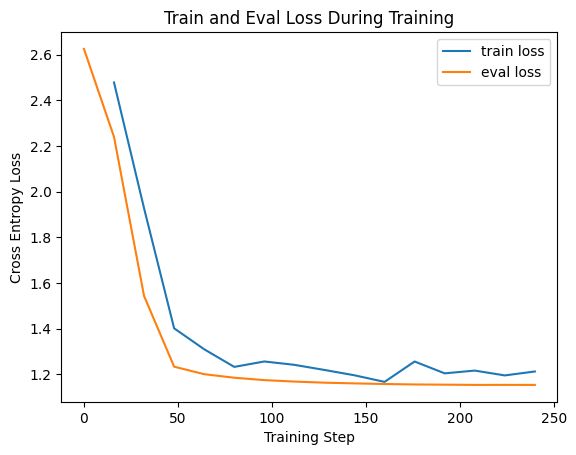

In [19]:
training_loss_history = []
eval_loss_history = [initial_eval_loss]
for step in trainer.state.log_history:
  if 'loss' in step:
    training_loss_history.append(step['loss'])
  elif "eval_loss" in step:
    eval_loss_history.append(step['eval_loss'])

print(training_loss_history)
print(eval_loss_history)

import matplotlib.pyplot as plt
time_steps = [i*16 for i in range(1, len(training_loss_history)+1)]
plt.plot(time_steps, training_loss_history, label="train loss")
plt.plot([0]+time_steps, eval_loss_history, label="eval loss")
plt.title("Train and Eval Loss During Training")
plt.xlabel("Training Step")
plt.ylabel("Cross Entropy Loss")
plt.legend(loc="upper right")
plt.show()

## Inference

In [20]:
modelpath = "./models/tiny-llama"

In [21]:
model = AutoModelForCausalLM.from_pretrained(
    modelpath,
    torch_dtype=torch.float16,
    device_map="auto",
)
tokenizer = AutoTokenizer.from_pretrained(modelpath)

loading configuration file config.json from cache at /home/hans/.cache/huggingface/hub/models--TinyLlama--TinyLlama-1.1B-Chat-v1.0/snapshots/fe8a4ea1ffedaf415f4da2f062534de366a451e6/config.json
Model config LlamaConfig {
  "_name_or_path": "TinyLlama/TinyLlama-1.1B-Chat-v1.0",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "eos_token_id": 2,
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 5632,
  "max_position_embeddings": 2048,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 22,
  "num_key_value_heads": 4,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": null,
  "rope_theta": 10000.0,
  "tie_word_embeddings": false,
  "torch_dtype": "float16",
  "transformers_version": "4.49.0",
  "use_cache": true,
  "vocab_size": 32000
}

loading weights file model.safetensors from cache

In [22]:
from peft import PeftModel, PeftConfig

base_model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
trained_adapter_dir = modelpath  # your checkpoint folder clearly stated here

# Load base tokenizer explicitly
tokenizer = AutoTokenizer.from_pretrained(base_model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

# Clearly load base model explicitly
base_model = AutoModelForCausalLM.from_pretrained(
    base_model_name,
    torch_dtype=torch.float16,
    device_map="auto",
    trust_remote_code=True
)

# Explicitly load your trained LoRA adapters clearly
model = PeftModel.from_pretrained(base_model, trained_adapter_dir)

# Set tokenizer explicitly
tokenizer = AutoTokenizer.from_pretrained(base_model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

model.eval()

# Use model explicitly for inference clearly
prompt = "When did Beyonce start becoming popular?"
inputs = tokenizer(prompt, return_tensors="pt").to("cuda")

with torch.no_grad():
    output = model.generate(**inputs, max_length=256)

response = tokenizer.decode(output.squeeze(), skip_special_tokens=True)
print(response)

loading file tokenizer.model from cache at /home/hans/.cache/huggingface/hub/models--TinyLlama--TinyLlama-1.1B-Chat-v1.0/snapshots/fe8a4ea1ffedaf415f4da2f062534de366a451e6/tokenizer.model
loading file tokenizer.json from cache at /home/hans/.cache/huggingface/hub/models--TinyLlama--TinyLlama-1.1B-Chat-v1.0/snapshots/fe8a4ea1ffedaf415f4da2f062534de366a451e6/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /home/hans/.cache/huggingface/hub/models--TinyLlama--TinyLlama-1.1B-Chat-v1.0/snapshots/fe8a4ea1ffedaf415f4da2f062534de366a451e6/special_tokens_map.json
loading file tokenizer_config.json from cache at /home/hans/.cache/huggingface/hub/models--TinyLlama--TinyLlama-1.1B-Chat-v1.0/snapshots/fe8a4ea1ffedaf415f4da2f062534de366a451e6/tokenizer_config.json
loading file chat_template.jinja from cache at None
loading configuration file config.json from cache at /home/hans/.cache/huggingface/hub/models--TinyLlama--TinyLlama-1.1B

When did Beyonce start becoming popular?

1. 2003: Beyonce releases her debut album, "Dangerously in Love."
2. 2004: Beyonce releases her second album, "B'Day."
3. 2005: Beyonce releases her third album, "I Am... Sasha Fierce."
4. 2006: Beyonce releases her fourth album, "Beyonce."
5. 2007: Beyonce releases her fifth album, "I Am... World Tour."
6. 2008: Beyonce releases her sixth album, "B'Day 2."
7. 2009: Beyonce releases her seventh album, "B'Day 3."
8. 2010: Beyonce releases her eighth album, "B'Day 4."
9. 2011: Beyonce releases her ninth album, "B'Day 5."
10. 2012: Beyonce releases her tenth album, "B'Day 6."
11. 2013: Beyonce
